In [1]:
### code to plot daily average temp & wind and slope of regression between freeboards and temp/wind

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import itertools
import tqdm
import datetime
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")

In [2]:
freebs = np.asarray(Dataset('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_CPOM/CS2_CPOM.nc')['Radar Freeboard'])
temps = np.load('/Users/carmennab/PhD/OI_PolarSnow/ERA5/temp/2010-2020.npy')
wind = np.load('/Users/carmennab/PhD/OI_PolarSnow/ERA5/wind/speed_2010-2020.npy')

In [3]:
days = np.arange(0,4018)
daily_freebs = []
daily_temps = []
daily_wind = []

for day in days:
    daily_freebs.append(np.nanmean(freebs[day]))
    daily_temps.append(np.nanmean(temps[day]))
    daily_wind.append(np.nanmean(wind[day]))

In [4]:
# calculate regional wind and temps

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')
nsidc_lat = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lats_v3.dat',dtype='<i4').reshape(448,304)/100000
nsidc_lon = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lons_v3.dat',dtype='<i4').reshape(448,304)/100000
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',round=True)
nsidc_x,nsidc_y = m(nsidc_lon,nsidc_lat)
file = Dataset('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/NSIDC_regions_Masks-2.nc')
mask = np.array(file['mask']).transpose(1,0).astype('float32')
mask_values = griddata((nsidc_x.ravel(),nsidc_y.ravel()),mask.ravel(),(x_WG,y_WG),'nearest')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Can. Arch.','Central Arctic']
regs = [6,7,8,9,10,11,12,13,14,15]

# function to calculate regional means 
def regions_WG(regs):
    WG_mean = np.full(4018,np.nan)
    WG_c = data.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean[day] = np.nanmean(WG_c[day])
    return(WG_mean)

# days where temp > 255
data = temps
temp_days = []
for region, reg in zip(regions, regs):
    region_temps = regions_WG(reg)
    temp_days.append((region_temps> 255).sum(axis = 0).astype(np.float32))
    
# days where wind > 5    
data = wind
wind_days = []
for region, reg in zip(regions, regs):
    region_wind = regions_WG(reg)
    wind_days.append((region_wind> 5).sum(axis = 0).astype(np.float32))

In [5]:
# calculate wind and temp slopes

# do smooth anoms for each grid cell

T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(freebs.shape,np.nan)
temp_anoms_big = np.full(freebs.shape,np.nan)
wind_anoms_big = np.full(freebs.shape,np.nan)

for day in tqdm.trange(freebs.shape[0]):
    
    # each day, make the 30 day running mean (15 either side)
    
    temp_30day = np.nanmean(temps[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    freeb_30day = np.nanmean(freebs[day-T1:day+T1],axis=0)
    wind_30day = np.nanmean(wind[day-T1:day+T1],axis=0)
    
    # now make anomalies from 30 day means
    
    temp_anoms_big[day] = temps[day] - temp_30day 
    freeb_anoms_big[day] = freebs[day] - freeb_30day
    wind_anoms_big[day] = wind[day] - wind_30day

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

fb_running_mean_anoms = np.full(freebs.shape,np.nan)
temp_running_mean_anoms = np.full(freebs.shape,np.nan)
wind_running_mean_anoms = np.full(freebs.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(freebs.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        temp_running_mean_anoms[day] = np.nanmean(temp_anoms_big[day-T2:day+T2],axis=0)
        wind_running_mean_anoms[day] = np.nanmean(wind_anoms_big[day-T2:day+T2],axis=0)

ps_wind = np.full((160,160), np.nan)
ss_wind = np.full((160,160), np.nan)
ps_temp = np.full((160,160), np.nan)
ss_temp = np.full((160,160), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    # calculate p and r for full timeseries per grid cell
    
    mask_temp = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(temp_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask_temp)) > 2: # if more than 2 days in snow and freeb have data then continue
        
        rstats = linregress(temp_running_mean_anoms[:,i,j][mask_temp],fb_running_mean_anoms[:,i,j][mask_temp]) # correlate valid snow and freeb for each grid cell 
        s = rstats.slope
        p = rstats.pvalue
        ss_temp[i,j] = s
        ps_temp[i,j] = p
        
    mask_wind = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(wind_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask_wind)) > 2: # if more than 2 days in snow and freeb have data then continue
        
        rstats = linregress(wind_running_mean_anoms[:,i,j][mask_wind],fb_running_mean_anoms[:,i,j][mask_wind]) # correlate valid snow and freeb for each grid cell 
        s = rstats.slope
        p = rstats.pvalue
        ss_wind[i,j] = s
        ps_wind[i,j] = p

100%|██████████████████████████████████████| 4018/4018 [00:07<00:00, 572.12it/s]
25600it [00:03, 6812.64it/s]


IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or Linear

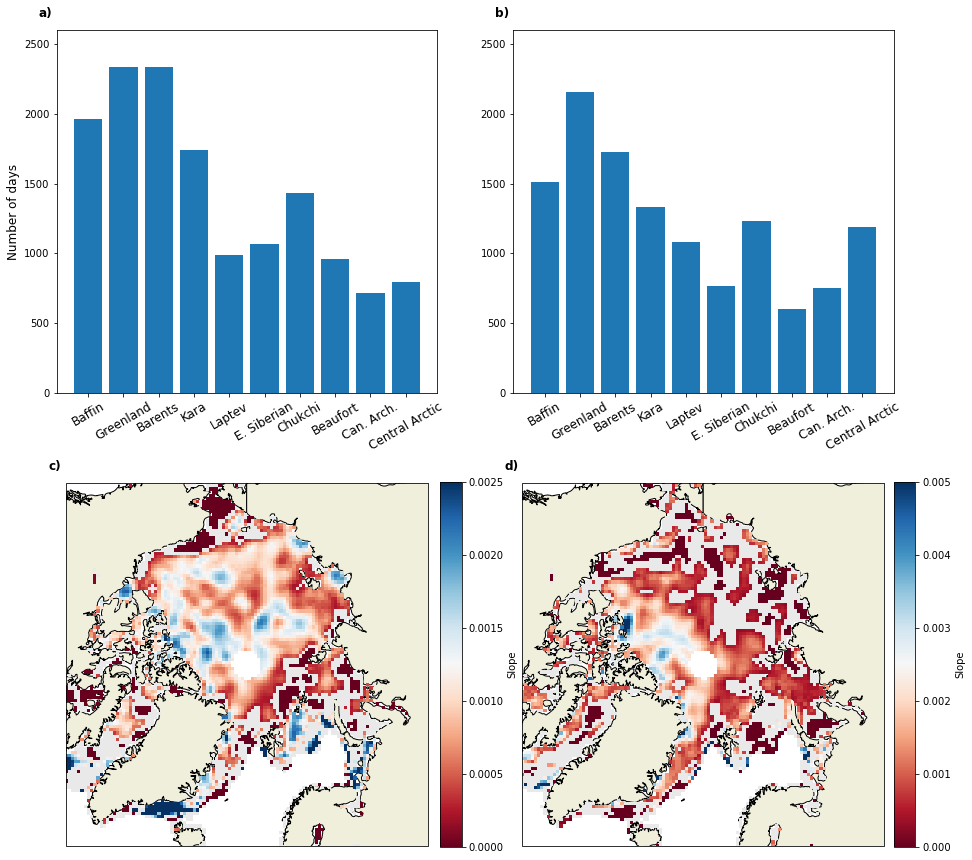

In [29]:
# combine all results into one plot to create Figure 2

lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

fig = plt.figure(figsize = (15,15))
spec = gridspec.GridSpec(ncols=2, nrows=2,hspace=0.25)

ax3 = fig.add_subplot(spec[0])
ax3 = plt.bar(regions, temp_days, 0.8, color='tab:blue')
plt.title('a)', x = -0.03,y = 1.02,fontweight="bold")
plt.ylabel("Number of days",fontsize='large')
plt.xticks(rotation=30,fontsize='large')
plt.ylim(0,2600)

ax4 = fig.add_subplot(spec[1])
ax4 = plt.bar(regions, wind_days, 0.8, color='tab:blue')
plt.title('b)', x = -0.03,y = 1.02,fontweight="bold")
plt.xticks(rotation=30,fontsize='large')
plt.ylim(0,2600)

ax5 = fig.add_subplot(spec[2], projection=ccrs.NorthPolarStereo())
ss_temp[ps_temp>0.05] = 1000
grey = ss_temp.copy()
grey[grey <1000] = np.nan
ax5.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax5.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax5.pcolormesh(lons,lats,ss_temp,cmap='RdBu',
                       vmin=0,vmax=0.0025,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax5.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('c)', x = -0.03,y = 1.02,fontweight="bold")
cbar_ax = fig.add_axes([0.48, 0.124, 0.02, 0.338])
a = fig.colorbar(p_map, cax=cbar_ax)
a.set_label('Slope')

ax6 = fig.add_subplot(spec[3], projection=ccrs.NorthPolarStereo())
ss_wind[ps_wind>0.05] = 1000
grey = ss_wind.copy()
grey[grey <1000] = np.nan
ax6.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax6.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax6.pcolormesh(lons,lats,ss_wind,cmap='RdBu',
                       vmin=0,vmax=0.005,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax6.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('d)', x = -0.03,y = 1.02,fontweight="bold")
cbar_ax = fig.add_axes([0.9, 0.124, 0.02, 0.338])
a = fig.colorbar(p_map, cax=cbar_ax)
a.set_label('Slope')

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/figures/temp_wind.png',bbox_inches = "tight")

In [ ]:
ax1 = fig.add_subplot(spec[0])
ax1 = plt.scatter(daily_freebs,daily_temps,c='tab:blue',s=10)
plt.title('a)', x = -0.03,y = 1.02,fontweight="bold")
plt.xlabel('Radar Freeboard (m)',fontsize='large')
plt.ylabel('Air Temperature (K)',fontsize='large')

ax2 = fig.add_subplot(spec[1])
ax2 = plt.scatter(daily_freebs,daily_wind,c='tab:blue',s=10)
plt.title('b)', x = -0.03,y = 1.02,fontweight="bold")
plt.xlabel('Radar Freeboard (m)',fontsize='large')
plt.ylabel('Wind Speed (m/s)',fontsize='large')